# import

In [1]:
import matplotlib.pyplot as plt
import numpy as np

import chainer

# データの取得

In [2]:
train, test = chainer.datasets.get_mnist()

# データセットの分割

split_dataset_random を使って train を訓練用と検証用にわける

In [3]:
from chainer.datasets import split_dataset_random

train, valid = split_dataset_random(train, int(len(train) * 0.7), seed=0)

In [4]:
print("len(train)",len(train))
print("len(valid)",len(valid))
print("len(test)",len(test))

len(train) 42000
len(valid) 18000
len(test) 10000


# SerialIterator

- バッチサイズで取り出し、エポックごとにシャッフル、を自動でやってくれるイテレータ
- `イテレータオブジェクト.next()` で自動的にバッチサイズ分を返してくれる

In [5]:
from chainer.iterators import SerialIterator

train_iter = SerialIterator(train, batch_size=10, repeat=True, shuffle=True)

minibatch = train_iter.next()

len(minibatch)

10

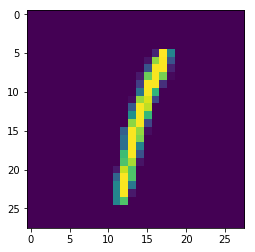

In [6]:
img = minibatch[0][0].reshape(28,28)
plt.imshow(img)

# ネットワークを決める

- chainer.Chain クラスを用いるとリンクを複数保持することができる
- Chain クラスは Link クラスを継承しているので、Link と同じことができる

In [7]:
import chainer
import chainer.links as L
import chainer.functions as F


class Net(chainer.Chain):

    def __init__(self, n_in=784, n_hidden=100, n_out=10):
        super().__init__()
        with self.init_scope():
            self.l1 = L.Linear(n_in, n_hidden)
            self.l2 = L.Linear(n_hidden, n_hidden)
            self.l3 = L.Linear(n_hidden, n_out)

    def forward(self, x):
        h = F.relu(self.l1(x))
        h = F.relu(self.l2(h))
        h = self.l3(h)

        return h

net = Net()

# 目的関数を決める

- `正則化`: 過学習を防ぐために`正則化項`などを付けること
- `重み減衰`: `L2正規化` とも呼ばれる。正規化項を足して、重みが大きくなりすぎないようにする 

Chainer はパラメータの更新方法をカスタマイズする方法として、２種類用意している

## optimizer hook

- ネットワークの持つすべてのパラメータに対して処理を行う
- `Optimizer` オブジェクトが持っている `add_hook()` メソッドに更新時に行いたい処理を渡して使用する

## UpdateRule

- ネットワークのパラメータ各々に対して処理を追加する
- パラメータが持っている `UodateRule` オブジェクトに対して `UpdateRule.add_hook()` を用いてカスタマイズしたい処理を追加する

Chainer は `chainer.optimizer_hooks` クラス以下に正則化手法がいくつか用意されている

In [8]:
for m in chainer.optimizer_hooks.__dir__():
    if not m.startswith('__'):
        print(m)

gradient_clipping
GradientClipping
gradient_hard_clipping
GradientHardClipping
gradient_lars
GradientLARS
gradient_noise
GradientNoise
lasso
Lasso
weight_decay
WeightDecay


重みを用いて、正則化を実現したオプティマイザを定義

In [9]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.SGD(lr=0.001)  # 学習率を 0.01 に設定
optimizer.setup(net)

for param in net.params():
    if param.name != 'b':  # バイアス以外だったら
        param.update_rule.add_hook(WeightDecay(0.0001))  # 重み減衰を適用

- パラメータは `Chain` クラスの `params()` メソッドによって取得ができる
- パラメータの中でもバイアスに対しては重みを追加しないようにするため、param.name が `b` であるパラメータを除いている
    - バイアスは L.Liner クラスの中で `b` という名前で定義されている
- `WeightDecay` クラスによって重みを作り、`add_hook()` によって追加している

#  最適化手法を選択する

- 今回は SGD ではなく、その改良版である MomentumSGD を用いてみる
- MomentumSGD は 前回の勾配を用いて工夫したもの
    - 引数の `momentum` は前回の勾配にかける倍率、多くの場合 0.9 が使われる

In [10]:
from chainer import optimizers
from chainer.optimizer_hooks import WeightDecay

optimizer = optimizers.MomentumSGD(lr=0.001, momentum=0.9)
optimizer.setup(net)

for param in net.params():
    if param.name != 'b':  # バイアス以外だったら
        param.update_rule.add_hook(WeightDecay(0.0001))  # 重み減衰を適用

In [13]:
gpu_id = 0

n_batch = 64  # バッチサイズ
n_epoch = 50  # エポック数

# ネットワークを GPU メモリ上に転送
net.to_gpu(gpu_id)

# ログ
results_train, results_valid = {}, {}
results_train['loss'], results_train['accuracy'] = [], []
results_valid['loss'], results_valid['accuracy'] = [], []

train_iter.reset()  # 上で一度 next() が呼ばれているため

count = 1

for epoch in range(n_epoch):

    while True:

        # ミニバッチの取得
        train_batch = train_iter.next()

        # x と t に分割
        # データを GPU に転送するために、concat_examples に gpu_id を渡す
        x_train, t_train = chainer.dataset.concat_examples(train_batch, gpu_id)

        # 予測値と目的関数の計算
        y_train = net(x_train)
        loss_train = F.softmax_cross_entropy(y_train, t_train)
        acc_train = F.accuracy(y_train, t_train)

        # 勾配の初期化と勾配の計算
        net.cleargrads()
        loss_train.backward()

        # パラメータの更新
        optimizer.update()

        # カウントアップ
        count += 1

        # 1エポック終えたら、valid データで評価する
        if train_iter.is_new_epoch:

            # 検証用データに対する結果の確認
            with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
                x_valid, t_valid = chainer.dataset.concat_examples(valid, gpu_id)
#                 x_valid, t_valid = chainer.dataset.concat_examples(valid)
                y_valid = net(x_valid)
                loss_valid = F.softmax_cross_entropy(y_valid, t_valid)
                acc_valid = F.accuracy(y_valid, t_valid)

            # 注意：GPU で計算した結果はGPU上に存在するため、CPU上に転送します
            loss_train.to_cpu()
            loss_valid.to_cpu()
            acc_train.to_cpu()
            acc_valid.to_cpu()

            # 結果の表示
            print('epoch: {}, iteration: {}, loss (train): {:.4f}, loss (valid): {:.4f}'
                  'acc (train): {:.4f}, acc (valid): {:.4f}'.format(
                epoch, count, loss_train.array.mean(), loss_valid.array.mean(),
                  acc_train.array.mean(), acc_valid.array.mean()))

            # 可視化用に保存
            results_train['loss'] .append(loss_train.array)
            results_train['accuracy'] .append(acc_train.array)
            results_valid['loss'].append(loss_valid.array)
            results_valid['accuracy'].append(acc_valid.array)

            break

epoch: 0, iteration: 4201, loss (train): 0.1548, loss (valid): 0.2292acc (train): 0.9000, acc (valid): 0.9333
epoch: 1, iteration: 8401, loss (train): 0.0592, loss (valid): 0.1836acc (train): 1.0000, acc (valid): 0.9463
epoch: 2, iteration: 12601, loss (train): 0.1069, loss (valid): 0.1544acc (train): 1.0000, acc (valid): 0.9546
epoch: 3, iteration: 16801, loss (train): 0.1287, loss (valid): 0.1366acc (train): 1.0000, acc (valid): 0.9599
epoch: 4, iteration: 21001, loss (train): 0.0201, loss (valid): 0.1282acc (train): 1.0000, acc (valid): 0.9609
epoch: 5, iteration: 25201, loss (train): 0.0065, loss (valid): 0.1144acc (train): 1.0000, acc (valid): 0.9659
epoch: 6, iteration: 29401, loss (train): 0.0678, loss (valid): 0.1038acc (train): 1.0000, acc (valid): 0.9686
epoch: 7, iteration: 33601, loss (train): 0.0582, loss (valid): 0.1002acc (train): 1.0000, acc (valid): 0.9701
epoch: 8, iteration: 37801, loss (train): 0.0044, loss (valid): 0.0969acc (train): 1.0000, acc (valid): 0.9697
epo

# 損失と精度の確認

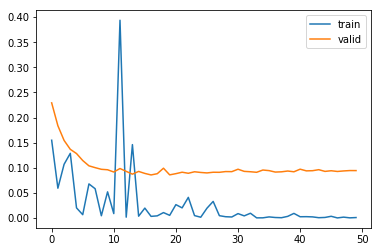

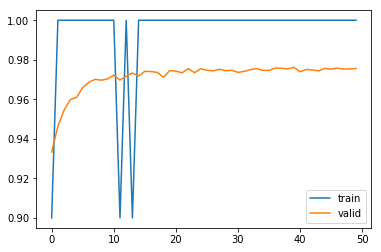

In [14]:
# 損失 (loss)
plt.plot(results_train['loss'], label='train')  # label で凡例の設定
plt.plot(results_valid['loss'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

# 精度 (accuracy)
plt.plot(results_train['accuracy'], label='train')  # label で凡例の設定
plt.plot(results_valid['accuracy'], label='valid')  # label で凡例の設定
plt.legend()  # 凡例の表示
plt.show()

In [15]:
# テストデータに対する損失と精度を計算
x_test, t_test = chainer.dataset.concat_examples(test, device=gpu_id)
with chainer.using_config('train', False), chainer.using_config('enable_backprop', False):
    y_test = net(x_test)
    loss_test = F.softmax_cross_entropy(y_test, t_test)
    acc_test = F.accuracy(y_test, t_test)

print('test loss: {:.4f}'.format(loss_test.array.get()))
print('test accuracy: {:.4f}'.format(acc_test.array.get()))

test loss: 0.0932
test accuracy: 0.9759


# ネットワークの保存

In [16]:
# 保存

from chainer.serializers import save_npz

net.to_cpu()

save_npz('net.npz', net)

In [17]:
# 読み込み

import numpy as np

load_params = np.load('net.npz')

for key, param in load_params.items():
    print(key, ':\t', param.shape)

l1/W :	 (100, 784)
l1/b :	 (100,)
l3/W :	 (10, 100)
l3/b :	 (10,)
l2/W :	 (100, 100)
l2/b :	 (100,)
